# Practice Lab: Swinging Up the Pendulum Using DDPG

**In this assignment, you will:**

1.   Develop a Deep Deterministic Policy Gradient (DDPG) agent for a **continuing** task, utilizing the **average reward** framework.
2.   Learn how to represent the policy as a NN for continuous action spaces.
3.   Explore methods to approximate and sample the gradient of the objective for updating the actor.
4.   Understand the process of updating the critic using the differential temporal difference (TD) error.

## Introduction

**Deep Deterministic Policy Gradient (DDPG)** is a model-free, off-policy reinforcement learning algorithm designed for handling continuous action spaces. It combines key elements of Deterministic Policy Gradient (DPG) and Deep Q-Network (DQN), utilizing Experience Replay and slow-updating target networks for enhanced stability.

## Problem

The goal is to solve the **Inverted Pendulum** control problem. Unlike discrete actions, where choices are limited (e.g., swing left or right), this task requires selecting from a continuous range of actions (`-2` to `+2`), making it challenging for traditional Q-Learning approaches.

<img src="https://mspries.github.io/img/jimmy-pendulum/pendulum.gif" alt="Drawing" style="width: 400px;"/>

## Quick Theory

DDPG follows an **Actor-Critic framework** with two main networks:
1. **Actor**: Proposes an action based on the current state.
2. **Critic**: Evaluates the quality of the action-state pair.

### Key Enhancements in DDPG:
1. **Target Networks**:
   - Stabilize training by slowly updating the target networks.
   - Prevent drastic changes in estimated targets during learning.

2. **Experience Replay**:
   - Stores past experiences `(state, action, reward, next_state)` in a replay buffer.
   - Learns by sampling from accumulated experiences, ensuring diverse and decorrelated training data.

These techniques collectively enable DDPG to handle continuous action spaces effectively while maintaining training stability.


## Install and Import Libraries

In [1]:
# Install Gymnasium for RL environment.
!pip install gymnasium

# Set up Keras and TensorFlow backend.
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import tensorflow as tf
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

## Create the Environment
Define the **Pendulum-v1** environment and retrieve its observation (state) and action spaces. These values determine the architecture of the networks.

In [11]:
# Initialize the Pendulum environment.
env = gym.make("Pendulum-v1")

# Extract the state and action dimensions.
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

# Print details about the environment.
print("Size of State Space:  {}".format(num_states))
print("Size of Action Space:  {}".format(num_actions))

# Get action bounds for clipping.
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action:  {}".format(upper_bound))
print("Min Value of Action:  {}".format(lower_bound))

Size of State Space:  3
Size of Action Space:  1
Max Value of Action:  2.0
Min Value of Action:  -2.0


## Define Ornstein-Uhlenbeck Noise
The Actor network's exploration is improved using Ornstein-Uhlenbeck (OU) noise, which generates temporally correlated noise.

Equation:

$x_{t+1}= x_t + θ(μ-x_t)\Delta t + \sigma \sqrt{\Delta t} N(0,1)$

For more details, check https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process

In [12]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

## Define Experience Replay Buffer

The Buffer class implements Experience Replay, which stores transitions $(s,a,r,s')$ and allows random sampling during training.

*   **Initialization:** Buffers are initialized to store states, actions, rewards, and next states for a fixed capacity.
*   **Record:** Adds an experience (state, action, reward, next_state) to the buffer in a circular manner.
*   **Update:** Computes and applies gradients for both the actor and critic networks using batches of experiences, with separate GradientTape blocks for each.
*   **Learn:** Samples a random batch of experiences from the buffer and calls the update method to train both networks.

**Critic Loss $L_{\text{critic}}$**

The loss for the critic network is computed as the Mean Squared Error (MSE) between the target Q-value $y$ and the predicted Q-value $Q(s, a; \theta_C)$:

$L_{\text{critic}} = \frac{1}{N} \sum_{i=1}^N \big(y_i - Q(s_i, a_i; \theta_C)\big)^2$

Where:
- $y = r + \gamma Q'(s', \pi'(s'; \theta_{\pi'}); \theta_{C'})$ is the target Q-value.
- $\gamma$ is the discount factor.
- $Q'(s', a'; \theta_{C'})$ is the target critic network's output for the next state-action pair.
- $\pi'(s'; \theta_{\pi'})$ is the action proposed by the target actor for the next state.

**Actor Loss $L_{\text{actor}}$**

The loss for the actor network is designed to maximize the Q-value predicted by the critic for the actions it generates. This is achieved by minimizing the negative Q-value:

$L_{\text{actor}} = -\frac{1}{N} \sum_{i=1}^N Q(s_i, \pi(s_i; \theta_\pi); \theta_C)$

Where:
- $\pi(s_i; \theta_\pi)$ is the action proposed by the actor network for state $s_i$.
- $Q(s_i, a; \theta_C)$ is the Q-value predicted by the critic for the given state and action.




In [19]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Initialize buffer with capacity and batch size, and empty arrays to store experiences
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.buffer_counter = 0  # Counter for keeping track of added experiences
        # Buffers to store states, actions, rewards, and next states
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    def record(self, obs_tuple):
        # Store a new experience (state, action, reward, next_state) in the buffer
        index = self.buffer_counter % self.buffer_capacity  # Circular buffer
        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.buffer_counter += 1  # Increment buffer counter

    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch):
        # Update the actor and critic networks with a batch of experiences

        # ------ Critic Update ------
        with tf.GradientTape() as tape:
            # 1) We obtain the target actions for the next states
            target_actions = target_actor(next_state_batch, training=True)
            # 2) We calculate the target y = r + gamma * Q'(s', a')
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions], training=True)
            # 3) We calculate the estimated value of the Critic for (s, a)
            critic_value = critic_model([state_batch, action_batch], training=True)
            # 4) Critic loss = MSE(y, critic_value)
            ### START CODE HERE ###
            critic_loss = keras.ops.mean(keras.ops.square(y - critic_value))
            ### END CODE HERE ###

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))

        # ------ Actor Update ------
        with tf.GradientTape() as tape:
            # Actions are predicted via the Actor
            actions = actor_model(state_batch, training=True)
            # Then we calculate the value of the Critic for (s, actions)
            critic_value = critic_model([state_batch, actions], training=True)
            # We want to maximize Q => we minimize -Q => actor_loss = -mean(Q)
            ### START CODE HERE ###
            actor_loss = -keras.ops.mean(critic_value)
            ### END CODE HERE ###

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(zip(actor_grad, actor_model.trainable_variables))

    def learn(self):
        # Sample a batch of experiences from the buffer and perform the update
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = keras.ops.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = keras.ops.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = keras.ops.convert_to_tensor(self.reward_buffer[batch_indices], dtype="float32")
        next_state_batch = keras.ops.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)

## Actor and Critic Networks

These networks approximate the policy $\pi(s)$ and value function $Q(s,a)$ respectively.

The Actor network in **Deep Deterministic Policy Gradient (DDPG)** is responsible for proposing continuous actions based on the current state. Below are some hints to guide you through its implementation:

1. **Input**: Accepts state (`num_states` dimensions).
2. **Hidden Layers**: Use two dense layers with 256 units each and `ReLU` activation.
3. **Output Layer**: A single action scaled by `tanh` to range `[-1, 1]`, then multiplied by `upper_bound`.
4. **Initialization**: Initialize the output layer's weights in the range `[-0.003, 0.003]` to prevent early gradient issues.
5. **Model**: Use `keras.Model` to connect inputs to outputs.

Focus on scaling the output correctly to match the environment's action range.


In [20]:
def get_actor():
    # Initialize weights for the last layer in a small range for stability
    last_init = keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    # Input layer for state representation
    inputs = layers.Input(shape=(num_states,))

    ### START CODE HERE ###
    # Two hidden layers with ReLU activation
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)

    # Output layer with tanh activation for action scale
    outputs = layers.Dense(
        num_actions,
        activation="tanh",
        kernel_initializer=last_init
    )(out)
    ### END CODE HERE ###

    # Scaling the output to match the action interval
    outputs = outputs * upper_bound

    # Creating and returning the actor model
    model = keras.Model(inputs, outputs)
    return model


The Critic network evaluates state-action pairs by predicting the Q-value, which represents the expected return for a given state-action combination.

1. **State Input**: Define an input layer for the state, with shape `(num_states,)`, representing the dimensions of the state space.
2. **Action Input**: Define another input layer for the action, with shape `(num_actions,)`, representing the dimensions of the action space.
3. **State Processing**: Pass the state input through two dense layers: the first with 16 units and the second with 32 units, both using `ReLU` activation.
4. **Action Processing**: Pass the action input through a dense layer with 32 units and `ReLU` activation.
5. **Concatenation**: Combine the processed state and action outputs using the `Concatenate` layer to feed them into the next layers.
6. **Hidden Layers**: After concatenation, pass the combined output through two dense layers with 256 units and `ReLU` activation.
7. **Final Output**: The final layer should output a single scalar value representing the value of the given state-action pair (Q-value).
8. **Model Construction**: Use `keras.Model` to create a model, linking the state and action inputs to the output.


In [21]:
def get_critic():
    # State input layer (shape: number of states)
    state_input = layers.Input(shape=(num_states,))

    ### START CODE HERE ###
    # First dense layer for state processing
    state_out = layers.Dense(256, activation="relu")(state_input)
    # Second dense layer for condition treatment
    state_out = layers.Dense(256, activation="relu")(state_out)

    # Action input layer (shape: number of actions)
    action_input = layers.Input(shape=(num_actions,))
    # Dense layer for action processing
    action_out = layers.Dense(256, activation="relu")(action_input)

    # Concatenate state and action outputs
    concat = layers.Concatenate()([state_out, action_out])

    # Dense layers for combined state-action processing
    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)

    # Final output layer with single neuron (Q value)
    outputs = layers.Dense(1)(out)
    ### END CODE HERE ###

    # Creation and return of the Critic model
    model = keras.Model([state_input, action_input], outputs)
    return model


`policy()` returns an action sampled from our Actor network with some noise for
exploration.

In [16]:
def policy(state, noise_object):
    sampled_actions = keras.ops.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

This update target parameters slowly. Based on rate `tau`, which is much less than one.

In [22]:
def update_target(target, original, tau):
    target_weights = target.get_weights()
    original_weights = original.get_weights()

    for i in range(len(target_weights)):
        ### START CODE HERE ###
        # “Soft” update of the target network:
        #θ_target ← τ * θ_original + (1 - τ) * θ_target
        target_weights[i] = tau * original_weights[i] + (1 - tau) * target_weights[i]
        ### END CODE HERE ###

    target.set_weights(target_weights)

## Training Loop

The main loop involves interaction with the environment, storing transitions, and training the networks.

1. **Initialize Parameters**:
   - Define noise for exploration (`OUActionNoise`) with standard deviation.
   - Initialize Actor and Critic networks and their target networks.
   - Set the target networks' weights equal to the Actor and Critic networks' weights.
   - Set learning rates for Critic and Actor.
   - Create optimizers for both networks using the Adam optimizer.
   - Set hyperparameters: total episodes, discount factor `gamma`, and soft update factor `tau`.
   - Initialize experience replay buffer.

2. **Training Loop**:
   - Loop through the total number of episodes.
   - Reset the environment to get the initial state for each episode.
   - Loop through the environment until done or truncated:
     - Convert the state to a tensor and pass it to the Actor to get an action using the policy and add exploration noise.
     - Take the action and get the next state, reward, and termination status from the environment.
     - Store the experience `(state, action, reward, next_state)` in the buffer.
     - Perform a learning step from the buffer.
     - Update the target networks using soft updates (`tau`).
     - If the episode ends (done or truncated), break the loop.

3. **Track and Plot Rewards**:
   - Track the episodic rewards and calculate the average reward.
   - Print the average reward at the end of each episode.


Episode 0, Avg Reward: -1561.8576408212575
Episode 1, Avg Reward: -1580.131446887353
Episode 2, Avg Reward: -1588.0565981478012
Episode 3, Avg Reward: -1556.2829234255964
Episode 4, Avg Reward: -1526.635097538865
Episode 5, Avg Reward: -1547.8264825064425
Episode 6, Avg Reward: -1533.6650016527049
Episode 7, Avg Reward: -1505.3182059196724
Episode 8, Avg Reward: -1463.1086340875527
Episode 9, Avg Reward: -1424.5592278513407
Episode 10, Avg Reward: -1387.6157048145653
Episode 11, Avg Reward: -1360.7169977769947
Episode 12, Avg Reward: -1335.9303038097753
Episode 13, Avg Reward: -1278.1650562944887
Episode 14, Avg Reward: -1236.0760869082094
Episode 15, Avg Reward: -1195.9087835893904
Episode 16, Avg Reward: -1155.6577958078324
Episode 17, Avg Reward: -1119.0135612197216
Episode 18, Avg Reward: -1073.972633368156
Episode 19, Avg Reward: -1026.8703847586944
Episode 20, Avg Reward: -993.7722256128551
Episode 21, Avg Reward: -954.9355786029645
Episode 22, Avg Reward: -929.7287815640569
Epis

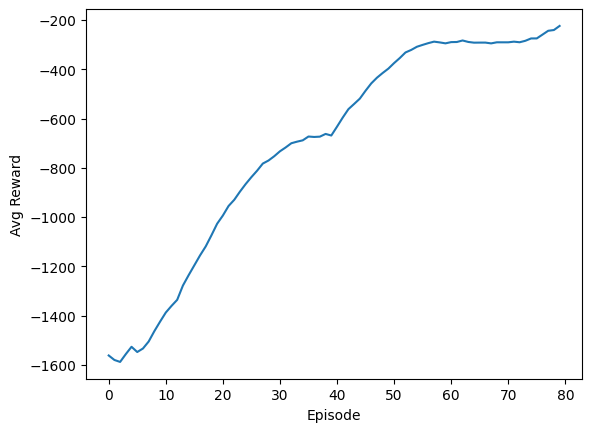

In [23]:
# Training hyperparameters
std_dev = 0.3
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = keras.optimizers.Adam(critic_lr)
actor_optimizer = keras.optimizers.Adam(actor_lr)

total_episodes = 80
gamma = 0.99
tau = 0.005

buffer = Buffer(50000, 64)

ep_reward_list = []
avg_reward_list = []

for ep in range(total_episodes):
    prev_state, _ = env.reset()
    episodic_reward = 0

    while True:
        tf_prev_state = keras.ops.expand_dims(keras.ops.convert_to_tensor(prev_state), 0)
        action = policy(tf_prev_state, ou_noise)
        state, reward, done, truncated, _ = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()

        update_target(target_actor, actor_model, tau)
        update_target(target_critic, critic_model, tau)

        if done or truncated:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-40:])
    print(f"Episode {ep}, Avg Reward: {avg_reward}")
    avg_reward_list.append(avg_reward)

plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg Reward")
plt.show()

# Save the weights
actor_model.save_weights("pendulum_actor.weights.h5")
critic_model.save_weights("pendulum_critic.weights.h5")

target_actor.save_weights("pendulum_target_actor.weights.h5")
target_critic.save_weights("pendulum_target_critic.weights.h5")


## Test the Actor Model

In [24]:
# Import additional libraries for GIF creation
import imageio

# Load the trained actor model weights
actor_model = get_actor()  # Re-initialize actor model structure
actor_model.load_weights("pendulum_actor.weights.h5")

# Test the trained model on the environment
test_env = gym.make("Pendulum-v1", render_mode="rgb_array")
frames = []

# Initialize environment and reset
state, _ = test_env.reset()
ep_reward = 0
disturbance_timer = 0

# Generate GIF by running the environment with the trained actor model
for timestep in range(1000):  # Run
    tf_state = tf.expand_dims(tf.convert_to_tensor(state), axis=0)
    action = policy(tf_state, lambda: 0)  # Use the trained actor policy, no noise

    # Add disturbance every 20 timesteps
    if timestep % 30 == 0:
        disturbance = np.random.uniform(-0.3, 0.3, size=(1,))
        action += disturbance
        prev_dist_action = action
        disturbance_timer = 10  # Set disturbance duration to 10 timesteps

    if disturbance_timer > 0:
        action = prev_dist_action  # Add disturbance to action
        disturbance_timer -= 1  # Decrease disturbance timer

    # Perform action and capture results
    state, reward, done, truncated, _ = test_env.step(action)

    ep_reward += reward

    # Capture frame for GIF
    frame = test_env.render()

    # Add the disturbance action to the frame
    import cv2
    from PIL import Image
    # Convert frame to a writable format (BGR for OpenCV)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    # Overlay disturbance information
    if disturbance_timer > 0:
        # Add disturbance text
        direction = "Right" if disturbance < 0 else "Left"
        cv2.putText(
            frame,
            f"Disturbance: {direction} ({disturbance[0]:.2f})",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 0, 0),
            2,
        )

        # Add disturbance arrow
        arrow_start = (frame.shape[1] // 2, frame.shape[0] // 5)
        arrow_end = (
            arrow_start[0] - int(400 * disturbance[0]),  # Scale arrow length by disturbance
            arrow_start[1],
        )
        cv2.arrowedLine(frame, arrow_start, arrow_end, (0, 0, 0), 3, tipLength=0.5)
    # Convert back to RGB for consistency with other processing steps
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Convert frame to PIL Image for GIF
    frame_pil = Image.fromarray(frame)

    frames.append(frame)

print(f"Total reward during test: {ep_reward}")

# Save frames as a GIF
gif_path = "./Pendulum_DDPG.gif"
imageio.mimsave(gif_path, frames, fps=20)

print(f"GIF saved at {gif_path}")


Total reward during test: -3680.10719687656
GIF saved at ./Pendulum_DDPG.gif


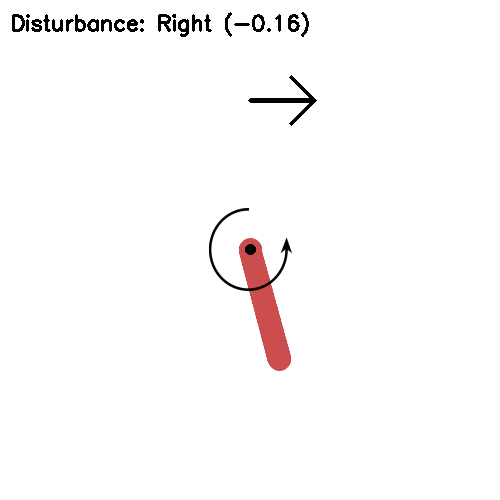

In [25]:
from IPython.display import display, Image

# Show GIF in notebook
display(Image(filename=gif_path))

## Conclsuion

Give your comment of what you have found as differences compared to the previous pratice lab (Actor Critic with Softmax Policy)

Answers :
Compared to the previous lab (Actor-Critic with a Softmax policy), the main differences are:

- **Continuous vs. Discrete Actions**: DDPG deals with continuous actions (Pendulum), whereas the previous lab used a discrete action space with a softmax policy.
- **Deterministic Policy**: DDPG’s actor outputs a single “best” action (plus external noise for exploration), rather than sampling from a probability distribution.
- **Two Neural Networks**: DDPG uses separate Actor and Critic networks plus their target counterparts, whereas the previous Actor-Critic method typically has a single network outputting both value and policy (or separate heads).
- **Use of Target Networks**: DDPG employs target networks for both actor and critic to stabilize learning, which differs from the simpler target or baseline approach in the previous lab.